In [9]:
from PIL import Image
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import requests
import random


In [6]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

im.size

(640, 480)

In [24]:
mask = torch.ones(im.size, dtype=torch.bool)
mask.shape

torch.Size([640, 480])

In [44]:

def rotate_im_mask(im, angle):
    if isinstance(im, Image.Image):
        im = T.functional.to_tensor(im)
    im = T.functional.rotate(im, angle)
    
    mask = torch.ones(im.shape[-2:], dtype=torch.bool)
    mask = T.functional.rotate(mask[None, ...], angle)
    return im, mask

ro_im, ro_mask = rotate_im_mask(im, 45)
ro_im.shape, ro_mask.shape

(torch.Size([3, 480, 640]), torch.Size([1, 480, 640]))

In [51]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

ro_mask_3ch = ro_mask.repeat(3, 1, 1)

In [57]:
grid = make_grid([ro_im, ro_mask_3ch], nrow=2)
grid.shape

torch.Size([3, 484, 1286])

In [58]:
pil_img = to_pil_image(grid)

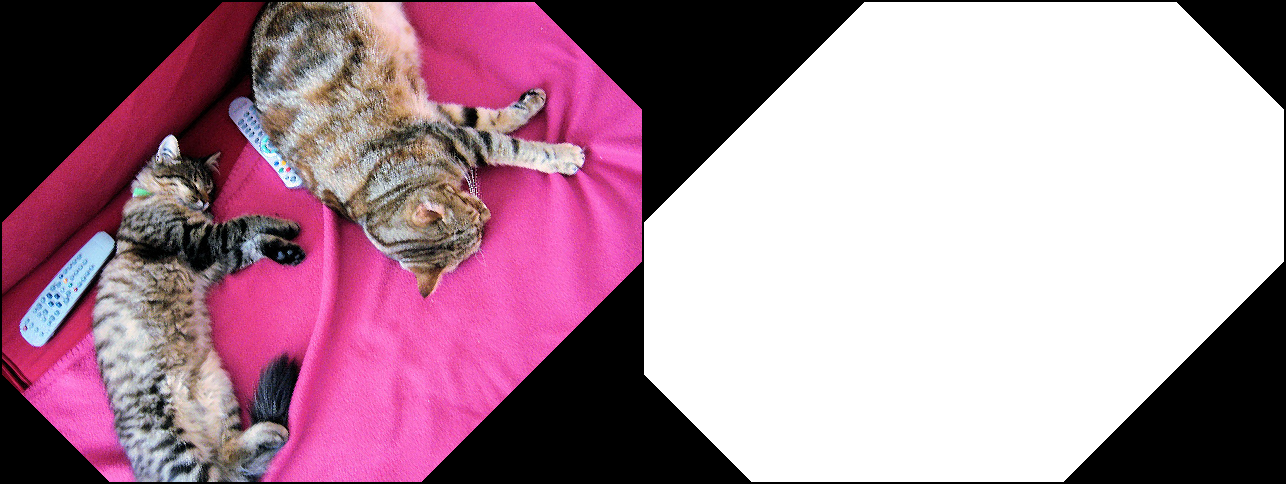

In [59]:
pil_img

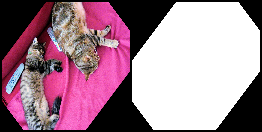

In [62]:
# resize it to 64 * 64 both image and mask

def resize_im_mask(im, mask, size):
    if isinstance(im, Image.Image):
        im = T.functional.to_tensor(im)
    im = T.functional.resize(im, size)
    
    mask = T.functional.resize(mask[None, ...].float(), size)
    mask = mask[0].bool()
    return im, mask

re_im, re_mask = resize_im_mask(ro_im, ro_mask, (128, 128))

# plot the resized image and mask

re_mask_3ch = re_mask.repeat(3, 1, 1)
grid = make_grid([re_im, re_mask_3ch], nrow=2)
pil_img = to_pil_image(grid)
pil_img

In [119]:
# make rotate part invalid with mask

import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Define a simple model architecture
        self.seq_convs = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        

    def forward(self, x, mask):
        # Apply the convolution operation
        x = self.seq_convs(x)
        
        # Example operation that uses the mask to ignore invalid areas
        # Here, we simply multiply the output by the mask to zero out invalid areas
        # Assuming mask is 1 for valid areas and 0 for invalid areas
        # The mask needs to be expanded to match the number of channels in x
        mask_expanded = mask.expand_as(x)
        out = x * mask_expanded.float()  # Ensure mask is float to multiply with x
        
        return out, mask_expanded

# Example usage
# Assuming ro_im is your rotated image tensor with shape [C, H, W]
# and ro_mask is your rotated mask tensor with shape [1, H, W]
model = CustomModel()

# You need to add a batch dimension to ro_im and ro_mask to match the expected input shape [N, C, H, W]
ro_im_batch = ro_im.unsqueeze(0)  # Add batch dimension
ro_mask_batch = ro_mask.unsqueeze(0)  # Add batch dimension

# Forward pass with image and mask
output, mask = model(ro_im_batch, ro_mask_batch)

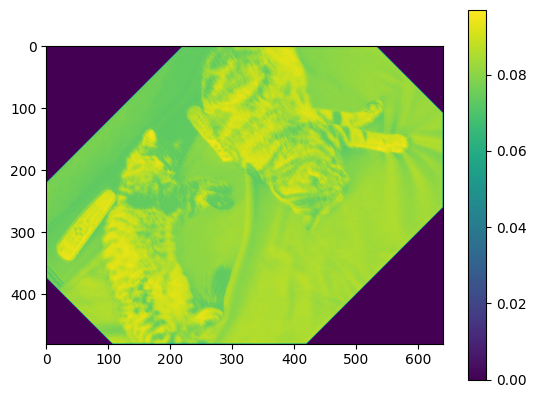

In [120]:
check = output.cpu().detach().numpy()
plt.imshow(check[0][2])
plt.colorbar()
plt.show()


In [124]:
mask.shape

torch.Size([1, 32, 480, 640])

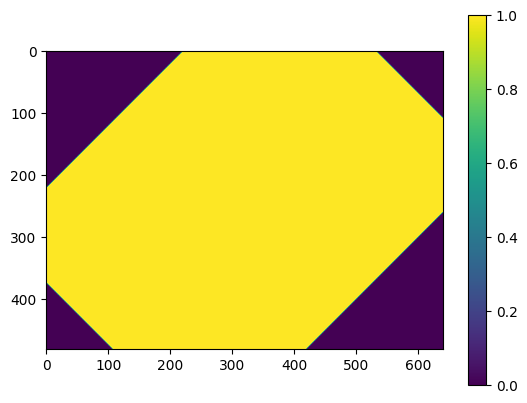

In [127]:
check = mask.cpu().detach().numpy()
plt.imshow(check[0][2])
plt.colorbar()
plt.show()

In [130]:
mask.dtype

torch.bool

In [110]:
check[0][0]

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [111]:
check[0][1]

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [65]:
output.shape

torch.Size([1, 16, 480, 640])

In [86]:
# make grid with all channels

grid = make_grid(list(output.permute(1, 0, 2, 3,).split(1)))


RuntimeError: The size of tensor a (480) must match the size of tensor b (640) at non-singleton dimension 3

In [99]:
from torchvision.transforms.functional import resize

# Permute and split the output tensor
output_list = list(output.permute(1, 0, 2, 3).split(1))

# Define the target size for resizing (e.g., 64x64)
target_size = (64, 64)

# Resize each tensor in the list to the target size
resized_output_list = [resize(tensor, size=target_size) for tensor in output_list]

# Create a grid from the resized tensors
grid = make_grid(resized_output_list)
grid

RuntimeError: output with shape [1, 1, 64] doesn't match the broadcast shape [1, 1, 64, 64]

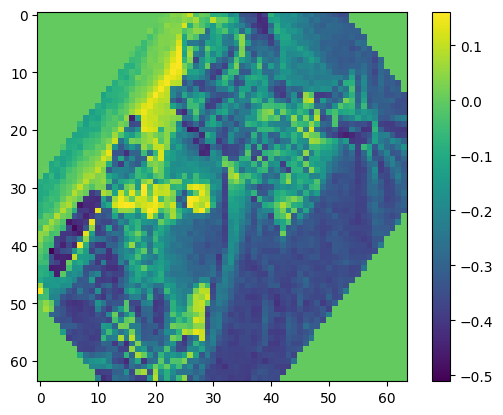

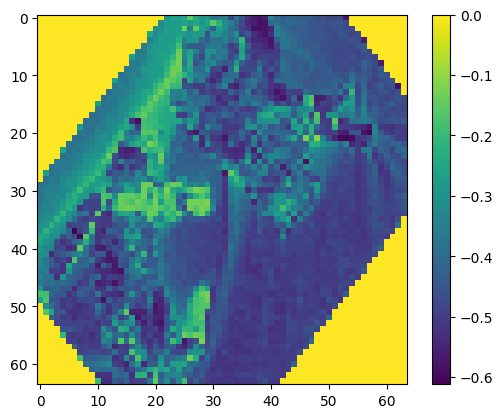

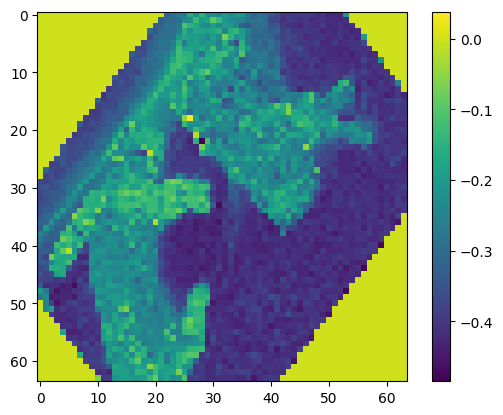

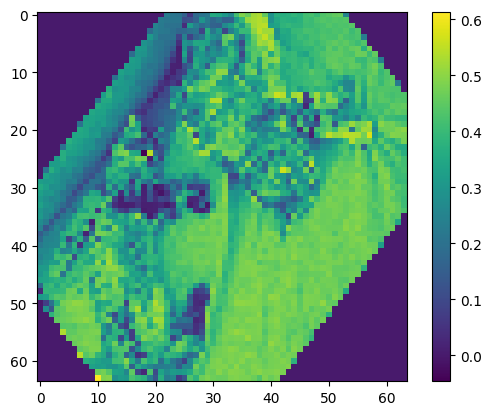

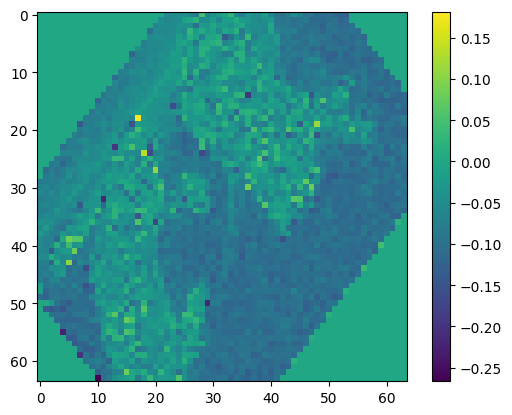

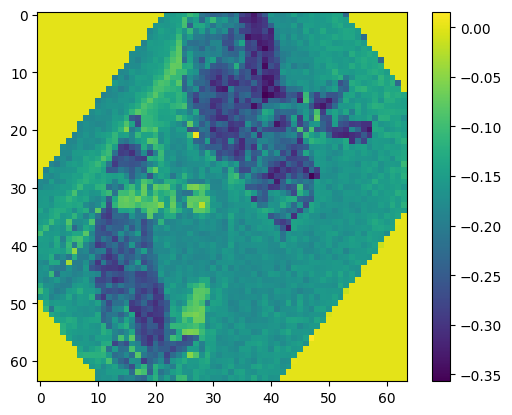

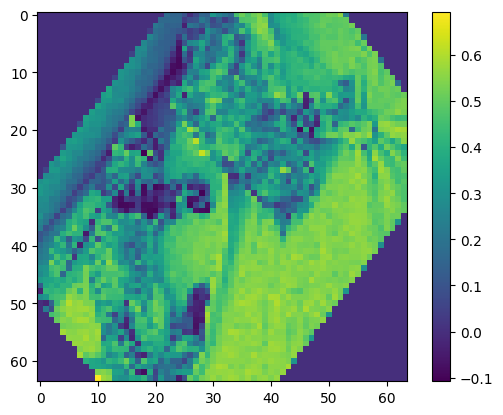

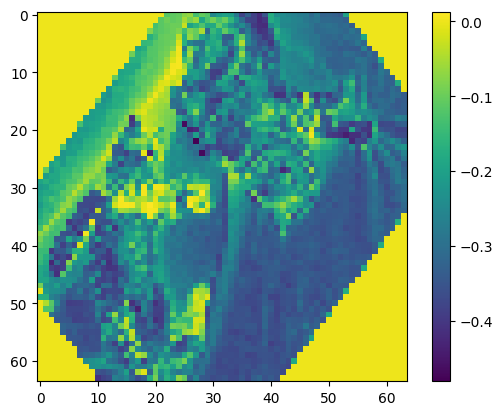

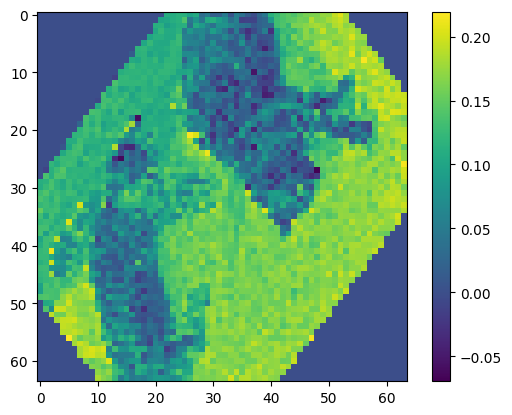

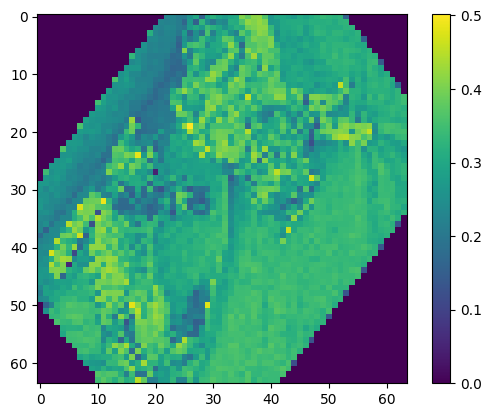

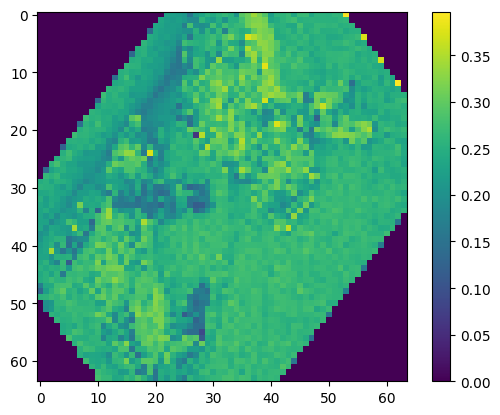

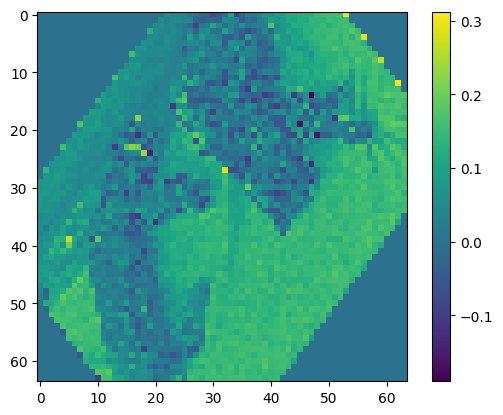

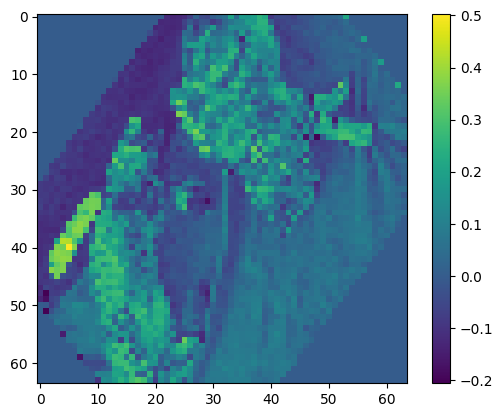

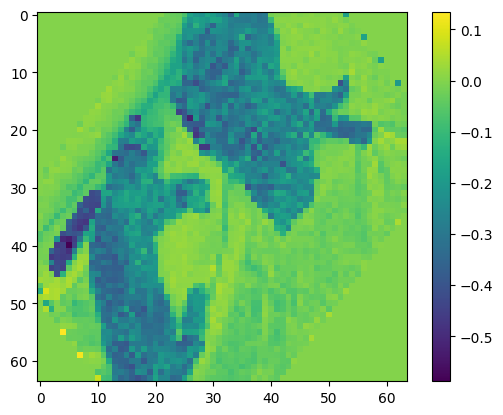

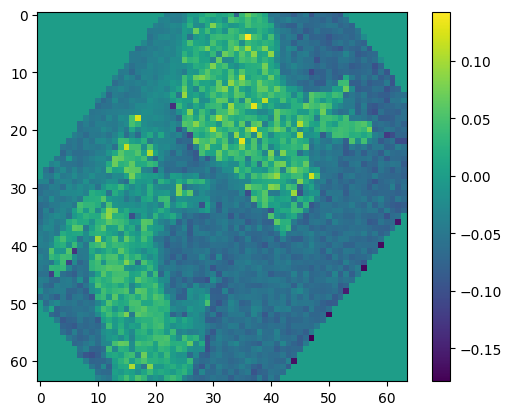

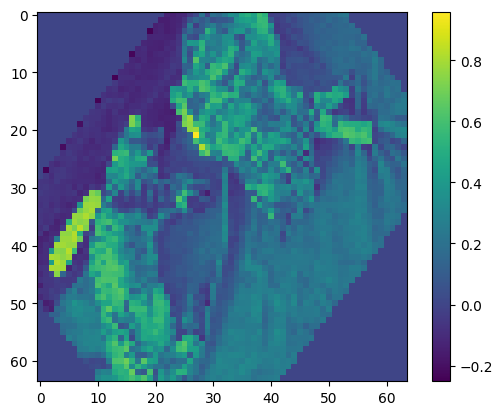

In [102]:
for i in resized_output_list:
    plt.imshow(i[0][0].detach().numpy())
    plt.colorbar()
    plt.show()
    
    

In [97]:
for i in t:
    print(i.shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


In [92]:
resized_output_list

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],
        grad_fn=<UpsampleBilinear2DBackward0>),
 tensor([[[[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]]]],
        grad_fn=<UpsampleBilinear2DBackward0>),
 tensor([[[[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]]]],
 